In [1]:
import requests
# import requests_cache
from dataclasses import dataclass, asdict
import numpy as np
import pandas as pd
import os, sys
import random
import math
import bisect
import arrow
import pytz
from datetime import datetime, date, timedelta
from timezonefinder import TimezoneFinder
from matplotlib import pyplot as plt, dates
from matplotlib.ticker import *
from carbon_api_client import *
from matplotlib_helper import *
from typing import List, Any
from dateutil import tz
from enum import Enum
from pprint import pprint
import functools

Given:
- data centers that are X hours apart, and
- max solar power is R times the average stable power

Questions:
- What’s the R needed to provide the same total power as stable power?
- How stable is the total power across all data centers when summed together?
- On a per-hour basis, how much workload (in MW) needs to be moved to git under the available solar power curve?


In [2]:
timezone_diff = 8
# max_solar_ratio = 2

In [3]:
DAY = timedelta(days=1)
TICK_STEP = timedelta(minutes=5)
TICK_COUNT = round(DAY.total_seconds() / TICK_STEP.total_seconds())

In [4]:
TOTAL_HOURS_IN_DAY = 24
# Shift by timezone_diff hours on each side until peak gets beyond [-12, +12]
extra_sites_per_side = TOTAL_HOURS_IN_DAY // 2 // timezone_diff
timezone_offsets = np.arange(-extra_sites_per_side, extra_sites_per_side + 1, 1) * timezone_diff
if timezone_offsets[-1] == TOTAL_HOURS_IN_DAY // 2:
    timezone_offsets = timezone_offsets[:-1]

In [5]:
def set_plot_styles():
    plt.xticks(np.linspace(0, TICK_COUNT, 9))
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: (x * TICK_STEP).total_seconds() / timedelta(hours=1).total_seconds()))
    plt.xlabel('UTC time of day (h)')
    plt.ylabel('Relative power')
    plt.xlim(0, TICK_COUNT)
    # plt.ylim(0, 1)
    plt.grid(alpha=0.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Sine-wave solar power from a single DC')

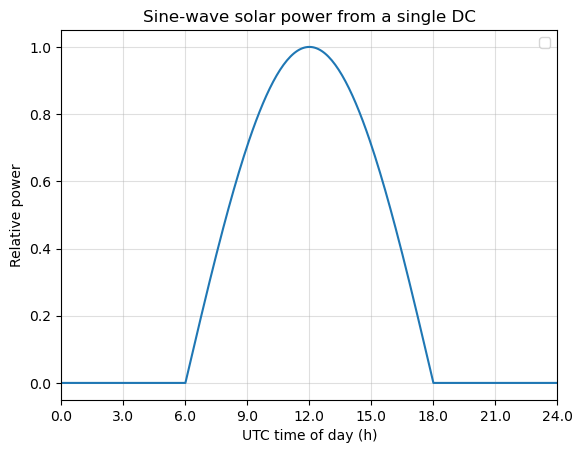

In [6]:
# Single data center sine-wave solar power

x = np.linspace(0, TICK_COUNT, TICK_COUNT + 1)
f = lambda x: max(0., np.sin((x - 0) * 2 * np.pi / TICK_COUNT - np.pi / 2))
y = np.vectorize(f)(x)
plt.plot(x, y)
set_plot_styles()
plt.legend()
plt.title('Sine-wave solar power from a single DC')

Text(0.5, 1.0, '')

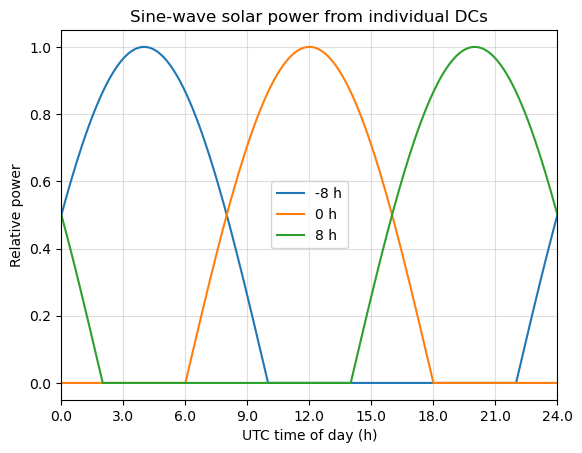

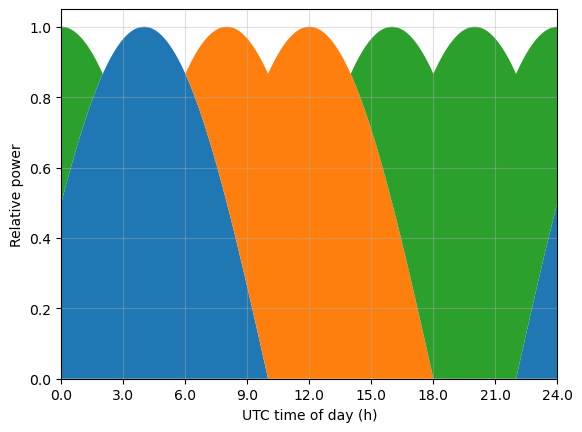

In [7]:
# Mulitple data centers total solar power
ys = []
for timezone_offset in timezone_offsets:
    tick_offset = timezone_offset * timedelta(hours=1) / TICK_STEP
    x = np.linspace(0, TICK_COUNT, TICK_COUNT + 1)
    f = lambda x: max(0., np.sin((x - tick_offset) * 2 * np.pi / TICK_COUNT - np.pi / 2))
    y = np.vectorize(f)(x)
    plt.plot(x, y, label=f'{timezone_offset} h')
    ys.append(y)
    # break
set_plot_styles()
plt.legend()
plt.title('Sine-wave solar power from individual DCs')

plt.figure()
plt.stackplot(x, *ys, baseline='zero')
set_plot_styles()
plt.title('')

In [8]:
# Q1: ratio needed to provide the same total power